In [1]:
# Packages used

import numpy as np
import matplotlib.pyplot as plt

import sympy
from sympy.plotting import plot
from sympy import lambdify

import scipy
from scipy import special
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import erlang
from scipy.stats import uniform

import random

import timeit
from datetime import datetime

import pandas as pd

from __future__ import division
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator

In [2]:
# Function that can be used to determine the runtime of a single cell, was implemented for personal use

def runtime(start=timeit.default_timer()):
    stop = timeit.default_timer()
    
    runtime_s = stop-start
    if runtime_s >= 60:
        if runtime_s>=60*60:
            runtime_h = runtime_s/(60*60)
            rest_m = (runtime_s/60)%60
            rest_s = rest_m%60
            print('Runtime: ', int(np.floor(runtime_h)), ' hours, ', int(np.floor(rest_m)), ' minutes and ', int(np.floor(rest_s)), ' seconds.')
        else:
            runtime_m = runtime_s/60
            rest_s = runtime_s%60
            print('Runtime: ', int(np.floor(runtime_m)), ' minutes and ', int(np.floor(rest_s)), ' seconds.')
    else:
        print('Runtime: ', int(np.floor(runtime_s)), ' seconds.')

In [3]:
# All symbols used for sympy

# Variable symbols
Lambda, alpha, beta, gamma = sympy.symbols('lambda, alpha, beta, gamma', real=True, positive=True)
t, s = sympy.symbols('t, s', real=True, positive=True)

# Rate and sigma parameter symbols, modify when working with values for m larger than 20
Rate_variables, Sigma_variables = [], []

Max_m = 20
for i in range(Max_m):
    Rate_variables.append(sympy.symbols('r_'+str(i), real=True))
    Sigma_variables.append(sympy.symbols('sigma_'+str(i), real=True))
    
# Used values and colors for m in the plots
range_m = [3, 5, 8]
colors_per_m = ['b', 'm', 'r']

# Functions used for simulations

In [5]:
# Simulation of a single path

def Simulate_One_Path(m=1, Lambda=1, Rates=np.ones(2), Time=np.linspace(0,10,101), Sigmas=np.ones(2), B_exponential=False, mu=1, B_fixed=False, unit_size=1, B_RV=False, C=1, epsilon=0.5):
    # m: total number of claims
    # Lambda: parameter of the exponential arrival distribution
    # Time: Range of times at which Y(t) is to be determined
    # Rates: drifts of the Lévy processes
    # Sigmas: standard deviation of the Brownian motion added to the Lévy processes
    
    # B_exponential: boolean variable to set the claim distribution to exponential
    # mu: parameter of the exponential claim distribution
    # B_fixed: boolean variable to set the claim distribution to fixed sizes
    # unit_size: sizes of the claims in case they are fixed
    # B_RV: boolean variable to set the claim distribution to regular varyaing
    # C: parameter for the regular varying distribution used
    # epsilon: parameter for the regular varying distribution used
    
    
    # Checks whether all r_0, ..., r_m rates have been given, Rates[n] = r_n in this case (same for sigma_n)
    if len(Rates) != m+1:
        print("Not enough or too many rates given: give m+1 rates")
    if len(Sigmas) != m+1:
        print("Not enough or too many sigmas given: give m+1 sigmas")
    
    
    # Generates arrival times
    Arrival_times = np.sort(expon.rvs(size=m, loc=0, scale=1/Lambda))
    
    
    # Generates claim sizes
    if B_exponential:
        Claim_sizes = expon.rvs(loc=0, scale=1/mu, size=m)
    elif B_fixed:
        Claim_sizes = unit_size*np.ones(m, dtype=float)
    elif B_RV: # RV claims
        uni = uniform.rvs(loc=0, scale=1, size=m)
        Claim_sizes = (C*(1/(1-uni)**(1/epsilon) - 1))
    else :
        print("No valid distribution for the claims has been given.")
        return 
    
    
    # Initial values of the simulation
    y = 0 # Keeps track of the amount in the system
    Y_t = [y] # Final list containing the values of the net cumulative claim process at the time points of Time
    
    y_max = 0 # Keeps track of the running maximum in the system
    Y_max_t = [y_max] # Final list containing the values of the running maximum of the net cumulative claim process at the time points of Time
    
    Claims_arrived = 0 # Keeps track of the number of claims that have arrived
    Claims_yet_to_arrive = m # Keeps track of the number of claims that have yet to arrive
    
    
    # Start of path simulation
    for i in range(1,len(Time)):
        Number_of_claims_interval = 0 # Determines how many arrivals out of the m customers take place in this interval
        
        # Counts number of arrivals in interval
        for j in range(m):
            if Time[i-1] <= Arrival_times[j] < Time[i]:
                Number_of_claims_interval += 1
        
        
        if Number_of_claims_interval == 0:
            # Samples what is added in total at the end of the interval
            Interval = Time[i] - Time[i-1]
            W_interval = norm.rvs(loc=0, scale=1)
            z = - Interval*Rates[Claims_yet_to_arrive]+Sigmas[Claims_yet_to_arrive]*np.sqrt(Interval)*W_interval
            
            # Samples the maximum reached within the interval
            W_max_int = 1/2 * z + 1/2*np.sqrt(z**2 - 2*Sigmas[Claims_yet_to_arrive]**2*Interval*np.log(uniform.rvs(loc=0, scale=1))) # is >=0
            y_max_int = y + W_max_int
            
            # Sets new value of y at the end of the interval
            y = y + z
            
            # Sets new maximum value of y at the end of the interval if necessary
            if y_max_int > y_max:
                y_max = y_max_int
        else :
            previous_arrival_time = Time[i-1]
            for j in range(Number_of_claims_interval):
                
                # Determines the length of the subinterval between two arrivals (or the arrival and the start of the interval)
                arrival_time = Arrival_times[Claims_arrived]
                Short_interval = arrival_time-previous_arrival_time
                
                # Samples what is added in total at the end of the subinterval
                W_interval = norm.rvs(loc=0, scale=1)
                z = -Short_interval*Rates[Claims_yet_to_arrive]+Sigmas[Claims_yet_to_arrive]*np.sqrt(Short_interval)*W_interval
                
                # Samples the maximum reached within the subinterval
                W_max_int = 1/2 * z + 1/2*np.sqrt(z**2 - 2*Sigmas[Claims_yet_to_arrive]**2*Short_interval*np.log(uniform.rvs(loc=0, scale=1))) # is >=0
                y_max_int = y + W_max_int
                
                # Sets new value of y at the end of the subinterval
                y = y + z
                
                # Sets new maximum value of y at the end of the subinterval if necessary
                if y_max_int > y_max:
                    y_max = y_max_int
                
                # Adds the claim to y at the end of the subinterval
                y += Claim_sizes[Claims_arrived]
                
                # Sets new maximum value of y including the claim at the end of the subinterval if necessary
                if y > y_max:
                    y_max = y
                
                Claims_arrived += 1
                Claims_yet_to_arrive -= 1
                previous_arrival_time = arrival_time

            
            # Sets length of final subinterval after last arrival in interval
            Short_interval = Time[i]-previous_arrival_time
            
            # Samples what is added in total at the end of the subinterval
            W_interval = norm.rvs(loc=0, scale=1)
            z = - Short_interval*Rates[Claims_yet_to_arrive]+Sigmas[Claims_yet_to_arrive]*np.sqrt(Short_interval)*W_interval

            # Samples the maximum reached within the subinterval
            W_max_int = 1/2 * z + 1/2*np.sqrt(z**2 - 2*Sigmas[Claims_yet_to_arrive]**2*Short_interval*np.log(uniform.rvs(loc=0, scale=1))) # is >=0
            y_max_int = y + W_max_int

            # Sets new value of y at the end of the subinterval
            y = y + z

            # Sets new maximum value of y at the end of the subinterval if necessary
            if y_max_int > y_max:
                y_max = y_max_int
            
        
        Y_t.append(y)
        Y_max_t.append(y_max)
        
    
    # Returns the arrival times, and the value of the free process and of its running maximum at the time points in Time
    return Arrival_times, Y_t, Y_max_t

In [83]:
# Parameter values for Figure 1
Value_m = 5
Value_lambda = 0.25
Value_mu = 0.1
Value_beta = 0.05

Value_sigmas = np.ones(Value_m+1)
Value_rates = np.arange(0,Value_m+1,1)



# Random seed number
Set_seed = True
SEED = 83
if Set_seed:
    np.random.seed(SEED)


# Gives one instance of a path
range_time = np.linspace(0,10,1001)
Arr_times, Y_t, Y_max_t = Simulate_One_Path(m=Value_m, Rates=Value_rates, Lambda=Value_lambda, Sigmas=Value_sigmas, Time=range_time, B_exponential=True, mu=Value_mu)
T_beta = expon.rvs(loc=0, scale=1/Value_beta)


# Saves the data of the path in a csv file
Dataframe_single_path = pd.DataFrame({'Time': range_time})
Dataframe_single_path.insert(1, "Path Value", Y_t, True)
Dataframe_single_path.insert(2, "Maximum Value", Y_max_t, True)

Dataframe_single_path.to_csv(r'c:Data Plots/Plot single path.txt', index=False, header=True, sep=',', mode='w')

C:\Users\dtrut\AppData\Local\Temp\ipykernel_9760\1359108881.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


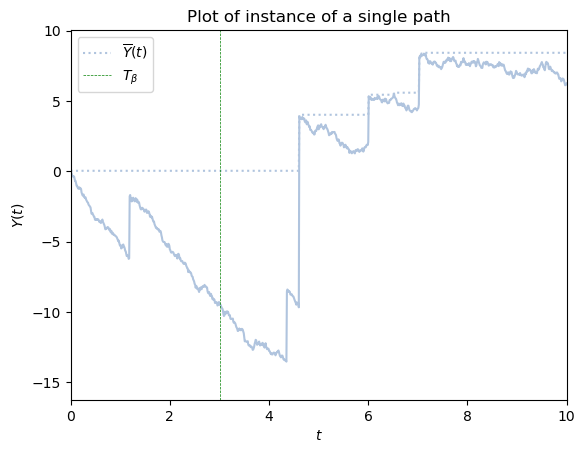

In [84]:
# Creates a figure with a plot of the path, same as Figure 1 in the paper

# Can choose to add a T_beta or not
Add_T_beta = True

# Makes the figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Sets limits axes
x_min = range_time[0]
x_max = range_time[-1]
y_min = 1.2*min(Y_t)
y_max = 1.2*max(Y_t)

# Plots the lines
line_1, = ax.plot(range_time, Y_t, color = 'lightsteelblue')
line_2, = ax.plot(range_time, Y_max_t, label='$\overline{Y}(t)$', linestyle='dotted', color='lightsteelblue')
if Add_T_beta:
    ax.vlines(T_beta, y_min, y_max, linestyle='dashed', linewidth=0.5, color = 'green', label=r'$T_{\beta}$')

# Sets axes    
ax.set_xlabel('$t$')
ax.set_xlim(x_min, x_max)
ax.set_ylabel('$Y(t)$')
ax.set_ylim(y_min, y_max)

# Makes legend and title
ax.legend()
ax.set_title('Instance of a single path')

# Shows and saves the figure
fig.show()
fig.savefig('Plot of instance of a single path')

In [6]:
def Simulate_mean_running_max(N=1000, m=1, Lambda=1, Rates=np.ones(2), Time=np.linspace(0,10,101), Sigmas=np.ones(2), B_exponential=False, mu=1, B_fixed=False, unit_size=1, B_RV=False, C=1, epsilon=0.5):
    # m: total number of claims
    # Lambda: parameter of the exponential arrival distribution
    # Time: Range of times at which Y(t) is to be determined
    # Rates: drifts of the Lévy processes
    # Sigmas: standard deviation of the Brownian motion added to the Lévy processes
    
    # B_exponential: boolean variable to set the claim distribution to exponential
    # mu: parameter of the exponential claim distribution
    # B_fixed: boolean variable to set the claim distribution to fixed sizes
    # unit_size: sizes of the claims in case they are fixed
    # B_RV: boolean variable to set the claim distribution to regular varyaing
    # C: parameter for the regular varying distribution used
    # epsilon: parameter for the regular varying distribution used
    
    
    Paths = []
    Running_Maximum_Paths = []
    
    # Samples N paths and stores them and the paths of their running maximums in lists
    for n in range(N):
        Arr_times, Y_t, Y_max_t = Simulate_One_Path(m=m, Lambda=Lambda, Rates=Rates, Time=Time, Sigmas=Sigmas, B_exponential=B_exponential, mu=mu, B_fixed=B_fixed, unit_size=unit_size, B_RV=B_RV, C=C, epsilon=epsilon)
        Paths.append(Y_t)
        Running_Maximum_Paths.append(Y_max_t)
    
        
    # Estimates the first and second moment of the running maximum at the desired time points
    Mean_running_max_Y_t = []
    Var_running_max_Y_t = []
    
    for t in range(len(Time)):
        running_mean = 0
        running_mean_sq = 0
        
        for n in range(N):
            running_mean += Running_Maximum_Paths[n][t]/N
            running_mean_sq += Running_Maximum_Paths[n][t]**2/N
        
        Mean_running_max_Y_t.append(running_mean)
        Var_running_max_Y_t.append(running_mean_sq - running_mean**2)        
            
    # Returns Monte Carlo based estimations for E[\bar{Y}(t)] and var(\bar{Y}(t)), and all the paths used for these estimations
    return np.array(Mean_running_max_Y_t), np.array(Var_running_max_Y_t), Running_Maximum_Paths

In [118]:
# Parameter values
Value_lambda = 0.25
Value_m = 5
Value_sigmas = np.ones(Value_m+1)
Value_mu = 0.1
Value_rates = np.arange(0,Value_m+1,1)


# Random seed number
Set_seed = True
SEED = 10
if Set_seed:
    np.random.seed(SEED)


# Gives estimates for the mean and variance of the running maximum of Y(t)
range_time = np.linspace(0,10,101)
Mean_running_max, Var_running_max, Paths = Simulate_mean_running_max(N=1000, m=Value_m, Rates=Value_rates, Lambda=Value_lambda, Sigmas=Value_sigmas, Time=range_time, B_exponential=True, mu=Value_mu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\dtrut\AppData\Local\Temp\ipykernel_17060\213991173.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


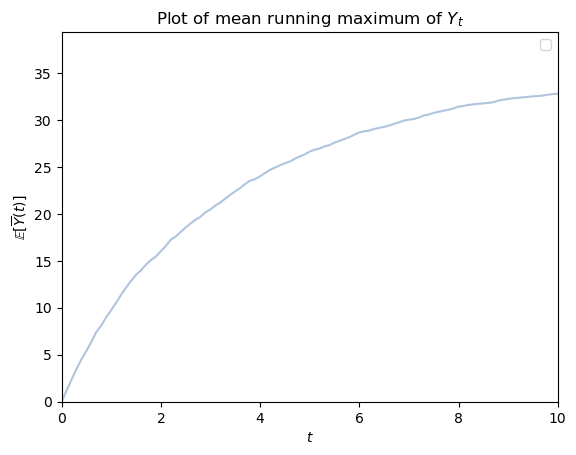

In [119]:
# Creates a figure with a plot of the mean of the running maximum - not used in the paper, just used for testing

# Makes the figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Sets limits axes
x_min = range_time[0]
x_max = range_time[-1]
y_min = 1.2*min(Mean_running_max)
y_max = 1.2*max(Mean_running_max)

# Plots the lines
line_1, = ax.plot(range_time, Mean_running_max, color = 'lightsteelblue')

# Sets axes    
ax.set_xlabel('$t$')
ax.set_xlim(x_min, x_max)
ax.set_ylabel(r'$\mathbb{E}[\overline{Y}(t)]$')
ax.set_ylim(y_min, y_max)

# Makes legend and title
ax.legend()
ax.set_title('Plot of mean running maximum of $Y_t$')

# Shows and saves the figure
fig.show()
fig.savefig('Plot of mean running maximum of $Y_t$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\dtrut\AppData\Local\Temp\ipykernel_17060\150734764.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


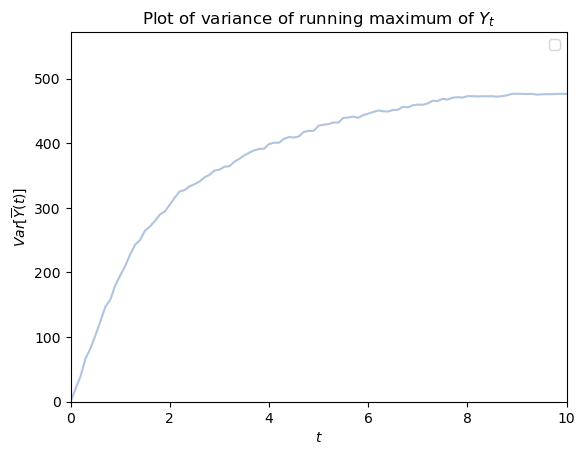

In [121]:
# Creates a figure with a plot of the variance of the running maximum - not used in the paper, just used for testing

# Makes the figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Sets limits axes
x_min = range_time[0]
x_max = range_time[-1]
y_min = 1.2*min(Var_running_max)
y_max = 1.2*max(Var_running_max)

# Plots the lines
line_1, = ax.plot(range_time, Var_running_max, color = 'lightsteelblue')
#line_2, = ax.plot(range_time, Y_max_t, label='$\overline{Y}(t)$', linestyle='dotted', color='lightsteelblue')

# Sets axes    
ax.set_xlabel('$t$')
ax.set_xlim(x_min, x_max)
ax.set_ylabel(r'$Var[\overline{Y}(t)]$')
ax.set_ylim(y_min, y_max)

# Makes legend and title
ax.legend()
ax.set_title('Plot of variance of running maximum of $Y_t$')

# Shows and saves the figure
fig.show()
fig.savefig('Plot of variance of running maximum of $Y_t$')

# Gaver's Laplace transform inversion algorithm

In [16]:
# Function that executes Gaver's inversion algorithm (see Joseph Abate and Ward Whitt, 1991, Proposition 8.2)

def GAVERs_method(Transform = 1/beta, Time = np.arange(0.0, 10.1, 0.1), Max_N=5):
    # Transform: the Laplace transform which is to be inverted w.r.t. the variable beta
    # Time: an array/list of time points at which the inverse Laplace transform is to be determined
    # Max_N: a parameter which controls the number of steps used in the summation, can be increased to attain more 
    #        accurate inversions. Be careful: for Max_N too large the precision of Python can become a problem, resulting 
    #        in a wrong inversion of the Laplace transform
    
    
    # Lambdifies the SymPy transform for faster calculations 
    Lambda_transform = lambdify(beta, Transform)
    
    
    # Here we enter the starting value of the inverse Laplace transform, because for t=0 we cannot determine the inverse value,
    # as dividing by 0 is impossible. Note that this is not 0 for all inverse transforms, but it is for the ones we consider
    List_inverse_t = [0]
    
    for t in Time[1:]:
        Inverse_t = 0
        
        for n in range(1,Max_N+1):
            # Determines the range of the beta's needed and calculates the transforms at those points
            Range_beta = np.log(2)/t * np.arange(n, 2*n+1, 1)
            f_in_range_beta = np.array([Lambda_transform(b) for b in Range_beta])

            # Single inverse function f_n
            Delta_n_f_n = sum(((-1)**np.arange(0,n+1) * scipy.special.comb(n, np.arange(0,n+1))) * f_in_range_beta)
            Inverse_t_n = np.log(2)/t * np.math.factorial(2*n)/(np.math.factorial(n)*np.math.factorial(n-1)) * Delta_n_f_n
            
            # Determines the weight
            w_n_Max_N = (-1)**(Max_N-n) * n**Max_N / (np.math.factorial(n) * np.math.factorial(Max_N-n))
            
            # Adds the weight and the inverse function f_n to the total
            Inverse_t += w_n_Max_N * Inverse_t_n
            
        List_inverse_t.append(Inverse_t)
        
    # Returns estimated values of the inverse Laplace transform at the time points in Time
    return np.array(List_inverse_t)

# Transforms and their inversions

### Exact derivation of the transforms $\pi_m(\alpha,\beta)$ in the deterministic drifts case

In [17]:
# Recursion of the transforms, returns all transforms pi_n for n=1,...,m

def Determine_all_Pi(m=1, Lambda=Lambda, alpha=alpha, beta=beta):
    Pi = sympy.Matrix.ones(1, m+1)
    
    for n in np.arange(1,m+1):
        r_n = Rate_variables[n]
        
        lambda_n = beta + Lambda*n        
        nu_n = lambda_n/r_n
        
        # Recursion step
        pi_n = beta/lambda_n + Lambda*n/lambda_n * nu_n/(nu_n-alpha) * (B_alpha*Pi[n-1] - alpha/nu_n * B_alpha.subs(alpha, nu_n) * Pi[n-1].subs(alpha,nu_n))
        Pi[n] = pi_n
        
    # Returns the sympy vector (pi_0, pi_1, ..., pi_m)
    return Pi


# Function that determines the first and second moment of the running maximum, E[\bar{Y}(T_\beta)] and E[\bar{Y}(T_\beta)^2], at an exponential point in time

def Determine_Transforms_Y(m=1, Lambda=Lambda, beta=beta):
    Pi = Determine_all_Pi(m=m, Lambda=Lambda, alpha=alpha, beta=beta)[-1]
    
    diff_pi = sympy.diff(Pi, alpha)
    diff_2_pi = sympy.diff(diff_pi, alpha)
    
    Transform_1st_Moment_Y = -1*diff_pi.subs(alpha, 0)
    Transform_2nd_Moment_Y = diff_2_pi.subs(alpha, 0)
    
    #Returns the transforms E[\overline{Y}(T_\beta)], E[\overline{Y}(T_\beta)^2]
    return Transform_1st_Moment_Y, Transform_2nd_Moment_Y

### Derivation of expectation running maximum for exponential claims

In [8]:
# Determines the distribution of the running maximum in the model with only positive drifts, used for Figure 2 in paper

# Parameter values
Value_lambda = 0.25 # General arrival rate, so that lambda_n^o = 0.25n
Value_mu = 0.25

# We use an exponential claim distribtuion. Here we define its parameter as a variable and its LST
mu = sympy.symbols('mu', real=True, positive=True)
B_alpha = mu / (mu + alpha)

In [13]:
start = timeit.default_timer()

# Random seed number
Set_seed = True
SEED = 100
if Set_seed:
    np.random.seed(SEED)

# Lists for the expectation and variance of \bar{Y}(t) over time.
List_Exp_Y_t = []
List_Var_Y_t = []

List_Exp_Y_t_sim = []
List_Var_Y_t_sim = []

# Time ranges used 
range_time_sim = np.linspace(0,10,101)
range_time_inv = np.linspace(0,10,101)

Dataframe_base_model = pd.DataFrame({'Time inv': range_time_inv, 'Time sim': range_time_sim})
counter = 0

for m in range_m:
    # Rates and sigmas used per m 
    Value_rates = np.arange(0,m+1, 1) #r_n = n for all n
    Value_sigmas = np.zeros(m+1) # sigma_n = 0 for all n
    
    
    # Gives the transforms of the first and second moment of \overline{Y}(t)
    Transform_Exp_Y, Transform_Exp_Y_sq = Determine_Transforms_Y(m=m, Lambda=Value_lambda)
    
    for n in range(m+1):
        Transform_Exp_Y = Transform_Exp_Y.subs([(Rate_variables[n], Value_rates[n])])
        Transform_Exp_Y_sq = Transform_Exp_Y_sq.subs([(Rate_variables[n], Value_rates[n])])
    
    Transform_Exp_Y = Transform_Exp_Y.subs(mu,Value_mu)
    Transform_Exp_Y_sq = Transform_Exp_Y_sq.subs(mu,Value_mu)
    
    
    # Applies Gaver's inversion algorithm to the tranforms
    Inverse_1st_moment = GAVERs_method(Transform=Transform_Exp_Y/beta, Time=range_time_inv)
    Inverse_2nd_moment = GAVERs_method(Transform=Transform_Exp_Y_sq/beta, Time=range_time_inv)
    Variance = Inverse_2nd_moment - Inverse_1st_moment**2
    
    List_Exp_Y_t.append(Inverse_1st_moment)
    List_Var_Y_t.append(Variance)
    
    
    # Estimates E[\overline{Y}(t)] and var(\overline{Y}(t)) through sampling of paths
    Mean_running_max, Var_running_max, Paths = Simulate_mean_running_max(N=50000, m=m, Rates=Value_rates, Lambda=Value_lambda, Sigmas=Value_sigmas, Time=range_time_sim, B_exponential=True, mu=Value_mu)
    List_Exp_Y_t_sim.append(Mean_running_max)
    List_Var_Y_t_sim.append(Var_running_max)
    
    
    # Saves the lists in the dataframe
    Dataframe_base_model.insert(1+counter, "EXP m = " + str(m) + " inv", Inverse_1st_moment, True)
    Dataframe_base_model.insert(2+counter, "VAR m = " + str(m) + " inv", Variance, True)
    
    Dataframe_base_model.insert(4+2*counter, "EXP m = " + str(m) + " sim", Mean_running_max, True)
    Dataframe_base_model.insert(5+2*counter, "VAR m = " + str(m) + " sim", Var_running_max, True)
    
    counter+=2
    
Dataframe_base_model.to_csv(r'c:Data Plots/Data base model.txt', index=False, header=True, sep=',', mode='w')

runtime(start)

Runtime:  27  minutes and  6  seconds.


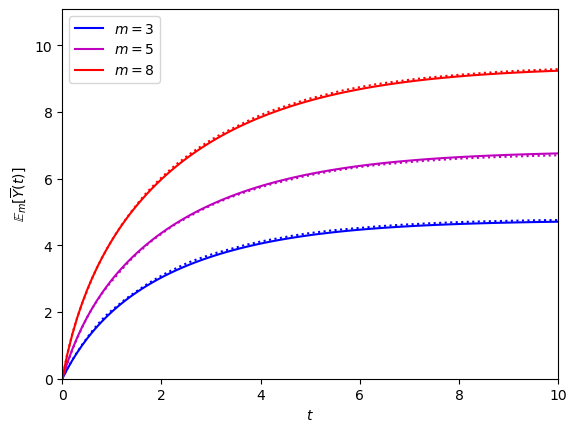

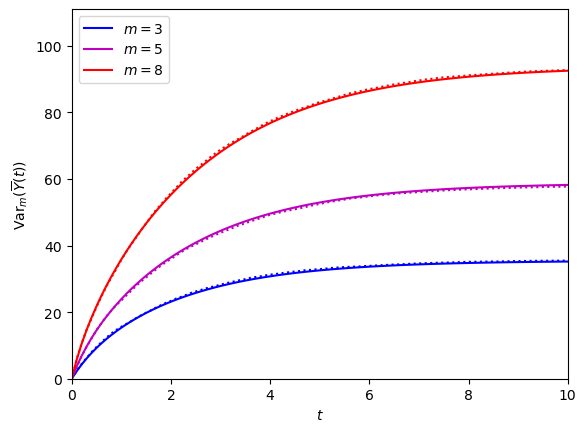

In [15]:
# First look at the result, which corresponds to Figure 2 in the paper

for k in range(len(range_m)):
    plt.plot(range_time_inv, List_Exp_Y_t[k], label='$m = $'+str(range_m[k]), color=colors_per_m[k])
    plt.plot(range_time_sim, List_Exp_Y_t_sim[k], linestyle='dotted', color=colors_per_m[k])
plt.xlim(0,10)
plt.ylim(0,1.2*float(max(List_Exp_Y_t[-1])))
plt.xlabel('$t$')
plt.ylabel('$\mathbb{E}_m[\overline{Y}(t)]$')
plt.legend(loc='upper left')#, reverse=True)
plt.show()

for k in range(len(range_m)):
    plt.plot(range_time_inv, List_Var_Y_t[k], label='$m = $'+str(range_m[k]), color=colors_per_m[k])
    plt.plot(range_time_sim, List_Var_Y_t_sim[k], linestyle='dotted', color=colors_per_m[k])
plt.xlim(0,10)
plt.ylim(0,1.2*float(max(List_Var_Y_t[-1])))
plt.ylabel('Var$_m(\overline{Y}(t))$')
plt.xlabel('$t$')
plt.legend(loc='upper left')#, reverse=True)

plt.show()

### Exact derivation of the transforms $\pi_n(\alpha,\beta)$ with decreasing Brownian Motion

In [9]:
# Determines the distribution of the running maximum in the model with a decreasing Brownian motion, used for Figure 3 in paper

def Determine_Pi_with_decreasing_BM(m=1, Lambda=Lambda, alpha=alpha, beta=beta):
    Pi = sympy.Matrix.ones(1, m+1) # Sympy vector with (pi_0, pi_1, ..., pi_m)
    Pi_o = sympy.Matrix.ones(1, m+1) # Sympy vector with (pi^o_0, pi^o_1, ..., pi^o_m)
    Z = sympy.Matrix.ones(1, m+1) # Sympy vector with the transforms of the Levy processes (Z_0, Z_1, ..., Z_m)
    
    # Initial step
    r_0, sigma_0 = Rate_variables[0], Sigma_variables[0]
    
    phi_0 = r_0*alpha + 1/2*sigma_0**2*alpha**2
    psi_0 = 1/sigma_0**2 * (-r_0 + sympy.sqrt(r_0**2 + 2*sigma_0**2*beta))
         
    Z[0] = (psi_0 - alpha)/(beta - phi_0) * beta/psi_0
    
    Pi[0] = (psi_0 - alpha)/(beta - phi_0) * beta/psi_0
    Pi_o[0] = 1
    
    
    # Recursion step
    for n in np.arange(1,m+1):
        lambda_n = beta + Lambda*n
        lambda_n_1 = beta + Lambda*(n-1)
        
        r_n, sigma_n = Rate_variables[n], Sigma_variables[n]
        
        phi_n = r_n*alpha + 1/2*sigma_n**2*alpha**2
        psi_n = 1/sigma_n**2 * (-r_n + sympy.sqrt(r_n**2 + 2*sigma_n**2*beta))
        
        Z[n] = (psi_n - alpha)/(beta - phi_n) * beta/psi_n
        
        Z_n_1_lambda_n_1 = Z[n-1].subs(beta, lambda_n_1)        
        psi_n_lambda_n = psi_n.subs(beta, lambda_n)
        
        pi_o_n = beta/lambda_n + Lambda*n/lambda_n * psi_n_lambda_n/(psi_n_lambda_n-alpha) * (B_alpha*Z_n_1_lambda_n_1*Pi_o[n-1] - alpha/psi_n_lambda_n * (B_alpha*Z_n_1_lambda_n_1*Pi_o[n-1]).subs(alpha,psi_n_lambda_n))
        Pi_o[n] = pi_o_n
        Pi[n] = Z[n].subs(beta, lambda_n)*Pi_o[n]
    
    # Returns (pi_0, pi_1, ..., pi_m)
    return Pi

def Determine_Transforms_Y_BM(m=1, Lambda=Lambda, alpha=alpha, beta=beta):
    Pi = Determine_Pi_with_decreasing_BM(m=m, Lambda=Lambda, alpha=alpha, beta=beta)[-1]
    
    diff_pi = sympy.diff(Pi, alpha)
    diff_2_pi = sympy.diff(diff_pi, alpha)
    
    Transform_1st_Moment_Y = -1*diff_pi.subs(alpha, 0)
    Transform_2nd_Moment_Y = diff_2_pi.subs(alpha, 0)
    
    #Returns E[\overline{Y}(T_\beta)], E[\overline{Y}(T_\beta)^2]
    return Transform_1st_Moment_Y, Transform_2nd_Moment_Y 

In [10]:
# Determines the distribution of the running maximum in the model with positive drifts and added Brownian motions, used for Figure 3 in paper

# Parameter values
Value_lambda = 0.25
Value_mu = 0.25

# We use an exponential claim distribtuion. Here we define its parameter as a variable and its LST
mu = sympy.symbols('mu', real=True, positive=True)
B_alpha = mu / (mu + alpha)

In [68]:
start = timeit.default_timer()

# Random seed number
Set_seed = True
SEED = 100
if Set_seed:
    np.random.seed(SEED)

# Lists for the expectation and variance of \overline{Y}(t) over time.
List_Exp_Y_t_BM = []
List_Var_Y_t_BM = []

List_Exp_Y_t_BM_sim = []
List_Var_Y_t_BM_sim = []

# Time ranges used 
range_time_sim = np.linspace(0,10,101)
range_time_inv = np.linspace(0,10,101)

Dataframe_model_with_BM = pd.DataFrame({'Time inv': range_time_inv, 'Time sim': range_time_sim})
counter = 0

for m in range_m:
    # Rates and sigmas used per m 
    Value_rates = np.arange(0,m+1, 1)
    Value_sigmas = np.ones(m+1)
    
    
    # Gives the transforms of the first and second moment of \overline{Y}(t)
    Transform_Exp_Y, Transform_Exp_Y_sq = Determine_Transforms_Y_BM(m=m, Lambda=Value_lambda)
    
    for n in range(m+1):
        Transform_Exp_Y = Transform_Exp_Y.subs([(Rate_variables[n], Value_rates[n]), (Sigma_variables[n], Value_sigmas[n])])
        Transform_Exp_Y_sq = Transform_Exp_Y_sq.subs([(Rate_variables[n], Value_rates[n]), (Sigma_variables[n], Value_sigmas[n])])
    
    Transform_Exp_Y = Transform_Exp_Y.subs(mu,Value_mu)
    Transform_Exp_Y_sq = Transform_Exp_Y_sq.subs(mu,Value_mu)
    
    
    # Applies Gaver's inversion algorithm to the tranforms
    Inverse_1st_moment = GAVERs_method(Transform=Transform_Exp_Y/beta, Time=range_time_inv)
    Inverse_2nd_moment = GAVERs_method(Transform=Transform_Exp_Y_sq/beta, Time=range_time_inv)
    Variance = Inverse_2nd_moment - Inverse_1st_moment**2
    
    List_Exp_Y_t_BM.append(Inverse_1st_moment)
    List_Var_Y_t_BM.append(Variance)
    
    
    # Estimates E[\overline{Y}(t)] and var(\overline{Y}(t)) through simulation
    Mean_running_max, Var_running_max, Paths = Simulate_mean_running_max(N=50000, m=m, Rates=Value_rates, Lambda=Value_lambda, Sigmas=Value_sigmas, Time=range_time_sim, B_exponential=True, mu=Value_mu)
    List_Exp_Y_t_BM_sim.append(Mean_running_max)
    List_Var_Y_t_BM_sim.append(Var_running_max)
    
    
    # Saves the data in an csv file
    Dataframe_model_with_BM.insert(1+counter, "EXP m = " + str(m) + " inv", Inverse_1st_moment, True)
    Dataframe_model_with_BM.insert(2+counter, "VAR m = " + str(m) + " inv", Variance, True)
    
    Dataframe_model_with_BM.insert(4+2*counter, "EXP m = " + str(m) + " sim", Mean_running_max, True)
    Dataframe_model_with_BM.insert(5+2*counter, "VAR m = " + str(m) + " sim", Var_running_max, True)
    
    counter+=2
    
Dataframe_model_with_BM.to_csv(r'c:Data Plots/Data model with BM.txt', index=False, header=True, sep=',', mode='w')

runtime(start)

Runtime:  27  minutes and  57  seconds.


In [ ]:
# First look at the result, which corresponds to Figure 3 in the paper

for k in range(len(range_m)):
    plt.plot(range_time_inv, List_Exp_Y_t_BM[k], label='$m = $'+str(range_m[k]), color=colors_per_m[k])
#    plt.plot(np.linspace(0,10,21), List_Exp_Y_t_BM_sim[k], linestyle='dashed', color=colors_per_m[k])
    plt.plot(np.linspace(0,10,101), List_Exp_Y_t[k], linestyle='dotted', color=colors_per_m[k])
#    plt.plot(range_time_sim, List_Exp_Y_t_sim[k], linestyle='dotted', color='k')
plt.xlim(0,10)
plt.ylim(0,1.2*float(max(List_Exp_Y_t_BM[-1])))
plt.xlabel('$t$')
plt.ylabel(r'$\mathbb{E}_m\,\overline{Y}(t)$')
plt.legend(loc='upper left', reverse=True)
plt.show()

for k in range(len(range_m)):
    plt.plot(range_time_inv, List_Var_Y_t_BM[k], label='$m = $'+str(range_m[k]), color=colors_per_m[k])
#    plt.plot(np.linspace(0,10,21), List_Var_Y_t_BM_sim[k], linestyle='dashed', color=colors_per_m[k])
    plt.plot(np.linspace(0,10,101), List_Var_Y_t[k], linestyle='dotted', color=colors_per_m[k])
#    plt.plot(range_time_sim, List_Var_Y_t_sim[k], linestyle='dotted', color='k')
plt.xlim(0,10)
plt.ylim(0,1.2*float(max(List_Var_Y_t_BM[-1])))
plt.ylabel(r'Var$_m(\overline{Y}(t))$')
plt.xlabel('$t$')
plt.legend(loc='upper left', reverse=True)

plt.show()

# Asymptotics ruin probability: phase type

In [11]:
# Function that estimates the probility of ruin before T_\beta, p_m(u, \beta), with Monte Carlo simulation

def Simulation_p_m_u_beta(N=1000, u=0, m=1, Lambda=1, Rates=np.ones(2), Beta=0, B_exponential=False, mu=1, B_erlang=False, K=2, B_RV=False, Value_C=1, Value_eps=0.5, B_unit=False, unit_size=1):
    number_of_u_reached = 0    
    
    # Regular Varying distribution
    if B_RV:
        u_var = sympy.symbols('u', positive=True, real=True)
        C = sympy.symbols('C', positive=True, real=True)
        epsilon = sympy.symbols('epsilon', real=True)

        F_u = 1 - C**epsilon / ((C+u_var)**epsilon)
        f_u = sympy.diff(F_u, u_var)
        inv_F_u = (C*(1/(1-u_var)**(1/epsilon) - 1)).subs(C,Value_C).subs(epsilon,Value_eps)
    
    # Generating paths
    for l in range(N):
        # Generates list of m+1 arrival times, note that we start with A_{(0)} = 0, and list of value and running max value of Y(t) at arrival times
        Arrival_times = [0] + list(np.sort(expon.rvs(size=m, loc=0, scale=1/Lambda)))
        Y_arrival_times = [0]
        Y_max_arrival_times = [0]
        
        # Generates list of m claim sizes
        if B_exponential: # Exponential claims
            Claim_sizes = expon.rvs(loc=0, scale=1/mu, size=m)
        elif B_erlang:
            Claim_sizes = erlang.rvs(a=K, loc=0, scale=1/mu, size=m)
        elif B_RV: # RV claims
            Claim_sizes = np.zeros(m, dtype=float)
            for i in range(m):
                uni = uniform.rvs(loc=0, scale=1)
                Claim_sizes[i] = inv_F_u.subs(u_var, uni)
        elif B_unit: # Unit sized claims
            Claims_sizes = unit_size*np.ones(m, dtype=float)
        else :
            print("No claim size distribution given.")
            return


        # Generates T_beta
        if Beta>0:
            T_beta = expon.rvs(loc=0, scale=1/Beta)
        else:
            T_beta = sympy.oo

        # Keeps track of value Y(t) at arrival times specifically
        Y_A_n = 0
        
        for n in range(m):
            # Checks wether T_beta is reached before the next arrival and u is reached before T_beta
            if Arrival_times[n] <= T_beta < Arrival_times[n+1]:
                if Y_max_arrival_times[n] >= u:
                    number_of_u_reached += 1
            
            # Determines value Y(t) at the next arrival time.
            Y_A_n_plus_1 = Y_A_n - Rates[m-n]*(Arrival_times[n+1] - Arrival_times[n]) + Claim_sizes[n]
            Y_arrival_times.append(Y_A_n_plus_1)
            
            # Sets new maximum value if previous maximum value is exceeded, otherwise keeps the same maximum value
            if Y_A_n_plus_1 > Y_max_arrival_times[n]:
                Y_max_arrival_times.append(Y_A_n_plus_1)
            else :
                Y_max_arrival_times.append(Y_max_arrival_times[n])
            
            Y_A_n = Y_A_n_plus_1
        
        # Final check if u is reached before T_beta in case T_beta later than the last arrival
        if T_beta >= Arrival_times[-1]:
            if Y_max_arrival_times[-1] >= u:
                number_of_u_reached += 1 
    
    # Returns estimate of the ruin probability p_m(u,beta)
    return number_of_u_reached/N



# Function that estimates the ruin probability, p_m(u), with Monte Carlo simulation

def Simulation_p_m_u(N=1000, u=0, m=1, Lambda=1, Rates=np.ones(2), B_exponential=False, mu=1, B_erlang=False, K=2, B_RV=False, Value_C=1, Value_eps=0.5, B_unit=False, unit_size=1):   
    
    # Regular Varying distribution
    u_var = sympy.symbols('u', positive=True, real=True)
    C = sympy.symbols('C', positive=True, real=True)
    epsilon = sympy.symbols('epsilon', real=True)
    
    F_u = 1 - C**epsilon / ((C+u_var)**epsilon)
    f_u = sympy.diff(F_u, u_var)
    inv_F_u = (C*(1/(1-u_var)**(1/epsilon) - 1)).subs(C,Value_C).subs(epsilon,Value_eps)
    
    number_of_u_reached = 0 
    
    # Generating paths
    for l in range(N):
        # Generates list of arrival times, note that we start with A_{(0)} = 0
        Arrival_times = [0] + list(np.sort(expon.rvs(size=m, loc=0, scale=1/Lambda)))
        Y_arrival_times = [0]
        Y_max_arrival_times = [0]

        if B_exponential: # Exponential claims
            Claim_sizes = expon.rvs(loc=0, scale=1/mu, size=m)
        elif B_erlang:
            Claim_sizes = erlang.rvs(a=K, loc=0, scale=1/mu, size=m)
        elif B_RV: # RV claims
            Claim_sizes = np.zeros(m, dtype=float)
            for i in range(m):
                uni = uniform.rvs(loc=0, scale=1)
                Claim_sizes[i] = inv_F_u.subs(u_var, uni)
        elif B_unit: # Unit sized claims
            Claims_sizes = unit_size*np.ones(m, dtype=float)
        else :
            print("No claim size distribution given.")
            return


        # Keeps track of value Y(t) at arrival times specifically
        Y_A_n = 0
        
        for n in range(m):
            # Determines value Y(t) at the next arrival time.
            Y_A_n_plus_1 = Y_A_n - Rates[m-n]*(Arrival_times[n+1] - Arrival_times[n]) + Claim_sizes[n]
            Y_arrival_times.append(Y_A_n_plus_1)
            
            # Sets new maximum value if previous maximum value is exceeded, otherwise keeps the same maximum value
            if Y_A_n_plus_1 > Y_max_arrival_times[n]:
                Y_max_arrival_times.append(Y_A_n_plus_1)
            else :
                Y_max_arrival_times.append(Y_max_arrival_times[n])
            
            # Check if u is already reached before following arrivals
            if Y_max_arrival_times[n+1] >= u:
                number_of_u_reached += 1
                break
            
            Y_A_n = Y_A_n_plus_1
    
    
    # Returns estimate of the total ruin probability p_m(u)
    return number_of_u_reached/N

### Erlang claims

In [4]:
# Determines the asymptotics of the ruin probability in the model with erlang distirbuted claims, used for Figure 4 in paper

# Symbols used in this section
u = sympy.symbols('u', positive=True, real=True)

beta = sympy.symbols('beta', positive=True, real=True)
Lambda = sympy.symbols('lambda', positive=True, real=True)

mu = sympy.symbols('mu', positive=True, real=True)

nu_1 = (Lambda + beta)/Rate_variables[1]

In [5]:
# Scale parameter in Erlang dist
d = 2

# Generates delta
delta = sympy.Matrix.zeros(d,1)
delta[0,0] = 1

if sum(delta) > 1:
    print("Not a valid initial distribution vector.")

# Generates S
S = sympy.Matrix.zeros(d,d)
S[0,0] = -mu
S[0,1] = mu
S[1,1] = -mu


# Generates the vector delta_1
delta_1 = (Lambda/(Lambda+beta)*nu_1 * delta.transpose()*((nu_1*sympy.eye(d) - S).inv())).transpose()

# Generates the matrix S_1 and the vector s_1
S_1 = sympy.Matrix.zeros(d,d)
for k in range(0,d):
    for l in range(0,d):
        S_1[l,k] = S[l,k]

s_1 = -1*S_1*sympy.Matrix.ones(d,1)


# List with all matrices S_n, starting with an empty slot so that All_S[n] = S_n
All_S = [[], S_1]
All_s= [[], s_1]

# List with all vectors delta_n, again starting with an empty slot
deltas = [[], delta_1]
deltas_prime = [[], delta_1]


# Total number of claims that will arrive
Value_m = 5

# Generates all S_n and delta_n
for n in range(2, Value_m+1):
    prev_S = All_S[-1]
    prev_s = All_s[-1]
    
    s_delta = prev_s*delta.transpose() # The matrix s*delta^T
    
    size_n_1 = prev_S.shape[0]    
    size_n = size_n_1 + d
    
    # Creates a matrix S_n of the correct size
    S_n = sympy.Matrix.zeros(size_n,size_n)
    
    # Fills the matrix S_n with the correct entries
    for i in range(0,size_n_1):
        for j in range(0,size_n_1):
            S_n[i,j] = prev_S[i,j]
    for i in range(0,d):
        for j in range(0,d):
            S_n[i+size_n_1,j+size_n_1] = S_1[i, j]
    for i in range(0,size_n_1):
        for j in range(0, d):
            S_n[i,j+size_n_1] = s_delta[i,j]
    
    # Determines the exit vector s_n
    s_n = -1*S_n*sympy.Matrix.ones(size_n,1)
    All_S.append(S_n)
    All_s.append(s_n)
    
    # Makes nu_n
    nu_n = (Lambda*n+beta)/Rate_variables[n]
    
    # Creates the vector delta'_n
    delta_n_prime = sympy.Matrix.zeros(size_n,1)
    temp_delta = deltas[n-1] # Takes the vector delta_{n-1}
    for k in range(0,size_n_1):
        delta_n_prime[k,0] = temp_delta[k,0]
    delta_n_1_zero_prob = (1 - (sympy.Matrix.ones(1,size_n_1)*temp_delta)[0])*delta
    for k in range(0,d):
        delta_n_prime[size_n_1+k,0] = delta_n_1_zero_prob[k,0]
    
    deltas_prime.append(delta_n_prime)
    
    # Determines the inverse (nu_n*I - S_n)^{-1}
    inverse = (nu_n*sympy.eye(size_n) - S_n).inv()
    
    delta_n = Lambda*n/(Lambda*n + beta) * (nu_n*delta_n_prime.transpose()*inverse).transpose()
    
    delta_n_nd1 = beta/(Lambda*n+beta) + Lambda*n/(Lambda*n+beta)*(delta_n_prime[0:size_n,0].transpose()*inverse*s_n)[0]
    deltas.append(delta_n)
    
F_u_erl = (deltas[-1].transpose()*sympy.exp(All_S[-1]*u)*sympy.ones(len(deltas[-1]),1))[0]
f_u_erl = (deltas[-1].transpose()*sympy.exp(All_S[-1]*u)*All_s[-1])[0]

In [11]:
# Asymptotics

# General parameters
Value_lambda = 1
Value_beta = 0.0
Value_rates = 0.01*np.arange(0, Value_m+1,1)

# Claim distribution parameters
Value_mu = 1

# Collects all parameters
Parameters = [(Lambda, Value_lambda), (beta, Value_beta), (mu, Value_mu)]

# Finds the highest order term
F_u_erl_2 = F_u_erl.subs(Parameters)
for n in np.arange(1,Value_m+1):
    F_u_erl_2 = F_u_erl_2.subs(Rate_variables[n], Value_rates[n])
Highest_order_term_erl = F_u_erl_2.coeff(u**(d*Value_m-1))*u**(d*Value_m-1)

Lambda_F_u_erl = lambdify(u, F_u_erl_2)
Lambda_highest_order_term_erl = lambdify(u, Highest_order_term_erl)

# Range of u
range_U = np.linspace(0, 30, 501)
range_U_1 = range_U[:250]
range_U_2 =  range_U[250:]

# Makes lists with the true, the asymptotic and the simulated ruin probabilities
True_values_p_u_erl = np.array([Lambda_F_u_erl(U) for U in range_U])
Asymptotics_values_p_u_erl = np.array([Lambda_highest_order_term_erl(U) for U in range_U])

In [15]:
# Range of u, split into three sub ranges, as the higher values of u acquire more paths in order to produce a good estimate for the ruin probability
range_U = np.linspace(0, 30, 501)
range_U_1 = range_U[:250]
range_U_2 =  range_U[250:450]
range_U_3 = range_U[450:]

start = timeit.default_timer()

Set_seed = True
SEED = 1000
if Set_seed:
    np.random.seed(SEED)
    
# Estimates the ruin probability per u using Monte Carlo simulation
Simulated_values_p_u_erl  =[]
for i in range(len(range_U_1)):
    U = range_U_1[i]    
    p = Simulation_p_m_u(N=200000, m=Value_m, u=U, Lambda=Value_lambda, Rates=Value_rates, B_erlang=True, K=2, mu=Value_mu)
    Simulated_values_p_u_erl.append(p)
    print(i, "/", len(range_U_1), " done")
for i in range(len(range_U_2)):
    U = range_U_2[i]    
    p = Simulation_p_m_u(N=500000, m=Value_m, u=U, Lambda=Value_lambda, Rates=Value_rates, B_erlang=True, K=2, mu=Value_mu)
    Simulated_values_p_u_erl.append(p)
    print(i, "/", len(range_U_2), " done")
for i in range(len(range_U_3)):
    U = range_U_3[i]    
    p = Simulation_p_m_u(N=1000000, m=Value_m, u=U, Lambda=Value_lambda, Rates=Value_rates, B_erlang=True, K=2, mu=Value_mu)
    Simulated_values_p_u_erl.append(p)
    print(i, "/", len(range_U_3), " done")
    
runtime(start)

0 / 250  done
1 / 250  done
2 / 250  done
3 / 250  done
4 / 250  done
5 / 250  done
6 / 250  done
7 / 250  done
8 / 250  done
9 / 250  done
10 / 250  done
11 / 250  done
12 / 250  done
13 / 250  done
14 / 250  done
15 / 250  done
16 / 250  done
17 / 250  done
18 / 250  done
19 / 250  done
20 / 250  done
21 / 250  done
22 / 250  done
23 / 250  done
24 / 250  done
25 / 250  done
26 / 250  done
27 / 250  done
28 / 250  done
29 / 250  done
30 / 250  done
31 / 250  done
32 / 250  done
33 / 250  done
34 / 250  done
35 / 250  done
36 / 250  done
37 / 250  done
38 / 250  done
39 / 250  done
40 / 250  done
41 / 250  done
42 / 250  done
43 / 250  done
44 / 250  done
45 / 250  done
46 / 250  done
47 / 250  done
48 / 250  done
49 / 250  done
50 / 250  done
51 / 250  done
52 / 250  done
53 / 250  done
54 / 250  done
55 / 250  done
56 / 250  done
57 / 250  done
58 / 250  done
59 / 250  done
60 / 250  done
61 / 250  done
62 / 250  done
63 / 250  done
64 / 250  done
65 / 250  done
66 / 250  done
67 / 

In [16]:
Dataframe_asymptotics_erl = pd.DataFrame({'u': range_U, 'True Values': True_values_p_u_erl, 'Asymptotic Values': Asymptotics_values_p_u_erl, 'Simulated Values': Simulated_values_p_u_erl})
Dataframe_asymptotics_erl.to_csv(r'c:Data Plots/Data asymptotics erl.txt', index=False, header=True, sep=',', mode='w')

C:\Users\dtrut\AppData\Local\Temp\ipykernel_28432\1555314803.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


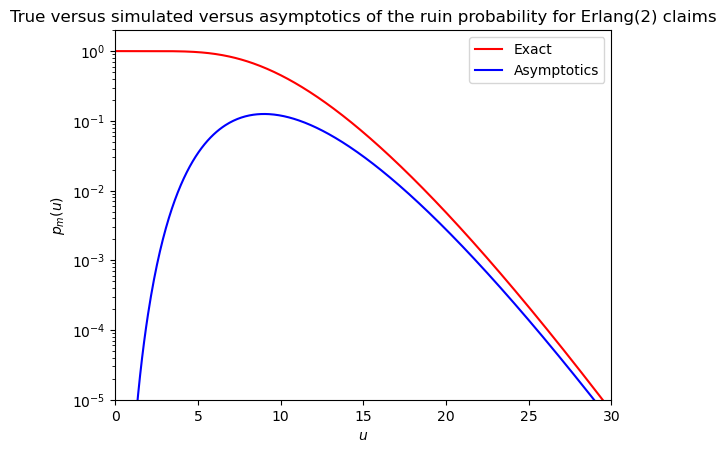

In [12]:
# First look at the result, which corresponds to Figure 4 in the paper

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line_1, = ax.plot(range_U, True_values_p_u_erl, color='red', linestyle= '-', label='Exact')
line_2, = ax.plot(range_U, Asymptotics_values_p_u_erl, color ='blue', label='Asymptotics')
#line_3, = ax.plot(range_U, Simulated_values_p_u_erl, color='black', label='Simulated', linewidth=0.5)
ax.legend()
ax.set_xlim(0,range_U[-1])
ax.set_title('True versus simulated versus asymptotics of the ruin probability for Erlang(2) claims')
ax.set_yscale('log')
ax.set_ylim(10**(-5),2)
ax.set_xlabel('$u$')
ax.set_ylabel('$p_m(u)$')

fig.show()
fig.savefig('Test plot asymptotics ruin probability erl')

# Asymptotics ruin probability: regular varying

In [13]:
# Determines the asymptotics of the ruin probability in the model with regular varying distirbuted claims, used for Figure 5 in paper

# Symbols used in this section
u = sympy.symbols('u', positive=True, real=True)
C = sympy.symbols('C', positive=True, real=True)
epsilon = sympy.symbols('epsilon', real=True)
eps = sympy.symbols('epsilon', real=True)

r = sympy.symbols('r', real=True)
Lambda = sympy.symbols('lambda', positive=True, real=True)
beta = sympy.symbols('beta', positive=True, real=True)

nu_1 = (Lambda + beta)/r

In [14]:
# General parameters
Value_m = 5
Value_lambda = 1
Value_beta = 0.0
Value_rates = np.arange(0, Value_m+1,1)**2
Value_rates = np.sqrt(np.arange(0, Value_m+1,1))

# Claim distribution parameters, for these values we have E[B] = 2
Value_C = 1
Value_eps = sympy.Rational(3/2)

# Derivation of B(alpha)
F_u_RV = 1 - Value_C**Value_eps / ((Value_C+u)**Value_eps)
f_u_RV = sympy.diff(F_u_RV, u)
B_alpha = sympy.integrate(sympy.exp(-alpha*u)*f_u_RV, (u,0,sympy.oo))

# Calulates the expectiaion of M
Exp_M = 0
for j in range(1,Value_m+1):
    temp_prod = 1
    for i in range(j,Value_m+1):
        temp_prod *= Lambda*i/(Lambda*i+beta)
    Exp_M += temp_prod

# Collects all parameters
Parameters = [(Lambda, Value_lambda), (beta, Value_beta), (C, Value_C), (epsilon, Value_eps)]

# Gives the asymptotics of the ruin probability p_m(u) = (1-F_u)
Lambda_Asymp_RV = lambdify(u, (Exp_M*(1-F_u_RV)).subs(Parameters))


# Range of u
range_U_RV = np.linspace(0, 30, 501)[1:]

# Makes list with simulated and asymptotics values for the ruin probability
Asymptotics_values_p_u_RV = np.array([Lambda_Asymp_RV(U) for U in range_U_RV])

In [18]:
# Makes list with numerically inverted values for the ruin probability

Pi_RV = Determine_all_Pi(m=Value_m, Lambda=Value_lambda, beta=Value_beta)[-1]
for n in range(Value_m+1):
    Pi_RV = Pi_RV.subs(Rate_variables[n], Value_rates[n])
Pi_RV = sympy.simplify(Pi_RV)

Rho_RV = (1-Pi_RV)/alpha

Numerical_inverse_values_p_u_RV = GAVERs_method_rho(Transform_p=Rho_RV, range_u=range_U_RV, Max_N=5)

In [26]:
start = timeit.default_timer()

# Makes list with simulated values for the ruin probability
Simulated_values_p_u_RV = []
for U in range_U_RV:
    p = Simulation_p_m_u(N=20000, m=Value_m, u=U, Rates=Value_rates, Lambda=Value_lambda, B_RV=True, Value_C=Value_C, Value_eps=Value_eps)
    Simulated_values_p_u_RV.append(p)
    print(U)

runtime(start)

0.0
0.06
0.12
0.18
0.24
0.3
0.36
0.42
0.48
0.54
0.6
0.6599999999999999
0.72
0.78
0.84
0.8999999999999999
0.96
1.02
1.08
1.14
1.2
1.26
1.3199999999999998
1.38
1.44
1.5
1.56
1.6199999999999999
1.68
1.74
1.7999999999999998
1.8599999999999999
1.92
1.98
2.04
2.1
2.16
2.2199999999999998
2.28
2.34
2.4
2.46
2.52
2.58
2.6399999999999997
2.6999999999999997
2.76
2.82
2.88
2.94
3.0
3.06
3.12
3.1799999999999997
3.2399999999999998
3.3
3.36
3.42
3.48
3.54
3.5999999999999996
3.6599999999999997
3.7199999999999998
3.78
3.84
3.9
3.96
4.02
4.08
4.14
4.2
4.26
4.32
4.38
4.4399999999999995
4.5
4.56
4.62
4.68
4.74
4.8
4.859999999999999
4.92
4.9799999999999995
5.04
5.1
5.16
5.22
5.279999999999999
5.34
5.3999999999999995
5.46
5.52
5.58
5.64
5.7
5.76
5.819999999999999
5.88
5.9399999999999995
6.0
6.06
6.12
6.18
6.24
6.3
6.359999999999999
6.42
6.4799999999999995
6.54
6.6
6.66
6.72
6.779999999999999
6.84
6.8999999999999995
6.96
7.02
7.08
7.14
7.199999999999999
7.26
7.319999999999999
7.38
7.4399999999999995
7.5
7.56

In [ ]:
Dataframe_asymptotics_RV = pd.DataFrame({'u': range_U_RV, 'Asymptotic Values': Asymptotics_values_p_u_RV, 'Numerical Inverse Values': Numerical_inverse_values_p_u_RV, 'Simulated Values': Simulated_values_p_u_RV})
Dataframe_asymptotics_RV.to_csv(r'c:Data Plots/Data asymptotics RV.txt', index=False, header=True, sep=',', mode='w')

C:\Users\dtrut\AppData\Local\Temp\ipykernel_28432\823277230.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


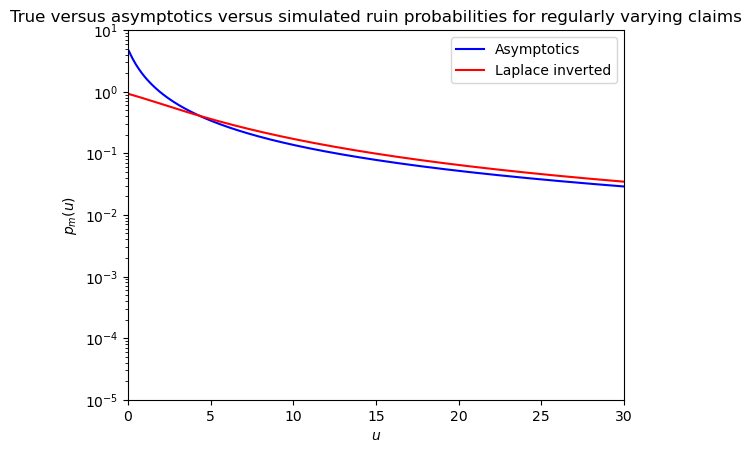

In [20]:
# First look at the result, which corresponds to Figure 5 in the paper

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line_1, = ax.plot(range_U_RV, Asymptotics_values_p_u_RV, color = 'blue', label='Asymptotics')
line_2, = ax.plot(range_U_RV, Numerical_inverse_values_p_u_RV, color = 'red', label='Laplace inverted')
#line_3, = ax.plot(range_U_RV, Simulated_values_p_u_RV, color = 'black', linewidth=0.5, label='Simulated', linestyle='-')

ax.legend()
ax.set_xlim(0,range_U_RV[-1])
ax.set_title('True versus asymptotics versus simulated ruin probabilities for regularly varying claims')
ax.set_yscale('log')
ax.set_ylim(10**(-5),10)
ax.set_xlabel('$u$')
ax.set_ylabel('$p_m(u)$')

fig.show()
#fig.savefig('Test plot asymptotics ruin probability RV')